# MP 8: Deep Learning for Grasping

**Due date**: April 2, 2021 at 10:45am.

**Instructions**: Read and complete the problems below. In this assignment, you should be switched over to a local install. 

For problems 2 and 3, you will need to install PyTorch on your system, or use the Binder environment.  It is also possible to use Google Colab if you want to use a GPU for training.  To do so, try `pip install torch`. If you have trouble with the install, try `pip install torch==1.8.0+cpu` for a CPU-only install.

To submit your assignment, perform the following:

1. Double-check that your programs run without error.
2. Submit this file, all of your .py files, and some illustrative predicted images (just the ones referenced in your written answers) on Moodle [http:/learn.illinois.edu](http:/learn.illinois.edu).
3. If you are using any external libraries other than the ones that are indicated during the installation process, include a README file indicating which library and version you are using.  To be on the safe side, you should include a backup procedure until the graders verify that they are able to support use of that library.

## Problem 1: Dataset generation

We'll augment the example RGB-D images and ground truth grasps from MP7 to see if we can create a dataset with wider scope.  We'll be using the grasps in the dataset `data/grasps/robotiq_85_more_sampled_grasps.json` which adds more (good and bad) grasp samples. We will be changing up the process in MP7 a bit by 1) using greater density of objects, 2) explicit collision checking between the gripper and the object, and 3) examining dense vs sparse prediction.

Like in MP7, we will generate world models by sampling base worlds (shelf, table, and box), object placements at random, then generating simulated RGB-D images, and finally generating grasp attribute images.

### Problem 1.A

In `gen_grasp_worlds`, implement a world sampler that has higher density of objects -- at least 3 per scene.  Use the stable faces logic of MP2, plus collision checking to generate worlds in which the objects rest in reasonable poses and are not colliding. The code provided for you will then save the world to `generated_worlds/world_XXXX.xml`. 

To visualize the worlds you've generated, run `klampt_browser generated_worlds/world_XXXX.xml`, or just run `klampt_browser` and click on each world file.  Note that you will need to run the program from the MP8 directory for the paths to be loaded properly.


### Problem 1.B

Next, generate camera images from a simulated camera with viewpoint variations. This will help make your predictor less sensitive to the particular viewpoint being used.  Some basic camera poses are predefined for you in the `resources` directory; if you want to edit these poses or set new poses you can uncomment out the "continue" marked under the TODO.  For each variation, perturb the position and orientation of the camera within 10-20 cm and 10-20 degrees, but bias these so that the camera still observes the scene.

This code will also generate grasp attribute images for your simulated camera but now also include a collision test to only retain grasps that can be reached without a collision.  This means you will need to sample various approach directions and determine whether the gripper collides.  There are two geometries here, one with the gripper open and the other with it closed to the desired width.  When sampling a grasp transform, if the open gripper collides with anything, don't use it.  If the closed gripper collides with anything *except the target object*, don't use it.  If you cannot find a valid approach direction, don't include the grasp in your grasp image.  

## Problem 2: Deep Learning for Image-Based Prediction

Next, you will learn image-based grasp prediction as in MP7, but you'll be using [PyTorch](https://scikit-learn.org/stable/) instead.  This is one of the most pleasant-to-use deep learning toolkits out there, and with a bit of scaffolding code it should work like magic.  (That's not to say that For most of you, you can install it on your local machine using `pip install torch`. You may also be able to use `pip install torch==1.8.0+cpu` if you find that the normal installation fails -- this will just use the CPU for training.  This is not a big deal; our problems are not ridiculously big and you might end up using the CPU to train anyways.  If all else fails, you can boot this notebook up on Binder or even try some GPU-based machines on Google Colab.



### Problem 2.A

In problem2.py, `make_patch_dataset` will extract some number of example patches from the image dataset to use for learning.  Just run this once to create a dataset of small images in the `patches` folder.

In this learning task, each example point will consist of a feature tensor $x_i$ and a target value $y_i$, and we will predict $y=f(x)$.  We'll just use the concatenation of the color and depth image patches as the feature tensor, which will be a 3D array of size 4 x patch_size x patch_size (the first index indicates R, G, B, and depth channels).  The target value will be a 4-D vector consisting of the score, width, heading, and elevation.  The train and test datasets will be drawn randomly from the patches.  The simple model provided for you will use a linear model followed by a rectified linear unit (ReLU).

Next, you will create a convolutional neural network to predict the output.   Create a convolutional neural network that uses two layers of:
- [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d), ReLU, and [max-pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d).

For the Conv2D layers, start by using a 3x3 convolution, 16 output channels, stride=1, and padding=1. Use 2x2 max-pooling.

Follow up the convolutional layers using a fully-connected network consisting of one hidden layer that performs:
- flattening,
- linear layer, output size 30,
- ReLU,
- another linear layer, output size 4

Train your model using the `train` function given above.  Compare the training process time, training curves, and ultimate RMSE on predicting the score attribute.  Place your response in the area for written answers below.


In [4]:
#load some basic utility code

%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import math
import time
import random

class Flatten(nn.Module):
  """Utility NN Module that flattens the incoming tensor."""
  def forward(self, input):
    return input.view(input.size(0), -1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Generates patches
import problem2

problem2.generate_patch_dataset()

Read 100 training images
Saved samples to patch_dataset/


Read 100 training images


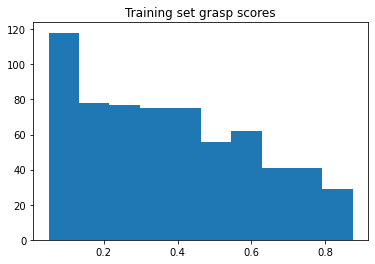

In [6]:
#Loads the patches and displays the distribution of grasp scores
%matplotlib inline
import matplotlib.pyplot as plt
import problem2

from torchvision import transforms
import torchvision.transforms.functional as TF

#If you want to experiment with color vs depth, you can try changing this to True...
#(Note that your networks will need to support 1 channel rather than 4 if the flag is set!)
DEPTH_ONLY = False

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class AddGaussianOffset(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        offset = random.gauss(self.mean,self.std)
        return tensor + torch.ones(tensor.size())*offset
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class ToTorchDataset:
    """a little shim code to pack the depth channel onto the color image and
    switch around the color channel order"""
    def __init__(self,patch_dataset):
        self.patch_dataset = patch_dataset
        #TODO: problem 2B: create a Transform object here to do data augmentation
        self.color_transform = None
        self.depth_transform = None
    def __len__(self):
        return len(self.patch_dataset)
    def __getitem__(self,idx):
        res = self.patch_dataset[idx]
        color = res['color']
        depth = res['depth']
        output = res['output']
        color = TF.to_tensor(color)
        depth = torch.from_numpy(depth[np.newaxis,:,:].astype(np.float32))
        if self.color_transform is not None:
            color = self.color_transform(TF.to_pil_image(color))
            color = TF.to_tensor(color)
        if self.depth_transform is not None:
            depth = self.depth_transform(depth)
        if DEPTH_ONLY:
            packed_image = depth
        else:
            packed_image = torch.cat((color,depth))
        return packed_image,output.astype(np.float32)

#sanity check
def plot_scores(dataset,title):
    data = []
    for input,output in dataset:
        data.append(output[0])
    plt.hist(data)
    plt.title(title)
    plt.show()

training_set = ToTorchDataset(problem2.PatchDataset('image_dataset','patch_dataset/train.csv'))
testing_set = ToTorchDataset(problem2.PatchDataset(training_set.patch_dataset.dataset,'patch_dataset/test.csv'))
testing_set.color_transform = None
testing_set.depth_transform = None
plot_scores(training_set,'Training set grasp scores')



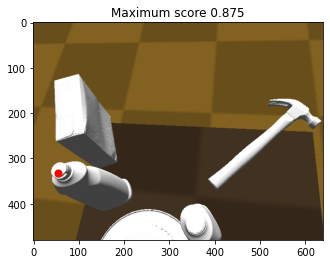

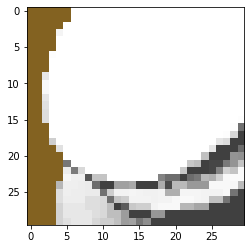

In [7]:
#Show the best patch, for a sanity check
best = training_set.patch_dataset.best_patch
score,img,x,y,color_patch,depth_patch = best
plt.title("Maximum score %.3f"%score)
plt.imshow(training_set.patch_dataset.dataset[img][0])
plt.scatter(x, y, s=50, c='red', marker='o')
plt.show()
plt.imshow(color_patch)
plt.show()

In [8]:
import torch.cuda as cuda

CUDA = cuda.is_available()
SEED = 1
BATCH_SIZE = 8
PATCH_SIZE = training_set.patch_dataset.patch_size

# Use a GPU, i.e. cuda:0 device if it available.
if CUDA:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print("Using device",device)

torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

# DataLoader instances will load tensors directly into GPU memory
kwargs = {'num_workers': 0, 'pin_memory': True} if CUDA else {}

train_loader = torch.utils.data.DataLoader(training_set,batch_size = BATCH_SIZE,shuffle=True,**kwargs)
test_loader = torch.utils.data.DataLoader(testing_set,batch_size = BATCH_SIZE,shuffle=True,**kwargs)


Using device cuda:0


In [9]:
#Scrap code to get a better sense of what the DataLoader does...
i = 0
for batch in train_loader:
    if i == 5:
        break
    input,output = batch
    print(input.__class__.__name__)  #Oh look, it's returning a Tensor
    print(input.size(),output.size())  #The leading dimension is 8!  That's the batch size.
    print(output)  #this is the 4-D output for 8 examples
    i+=1

Tensor
torch.Size([8, 4, 30, 30]) torch.Size([8, 4])
tensor([[0.0510, 0.0510, 0.9569, 0.4314],
        [0.0980, 0.1922, 0.4157, 0.0471],
        [0.2667, 0.0118, 0.4627, 0.7804],
        [0.0745, 0.9098, 0.0157, 0.3412],
        [0.2706, 0.8431, 0.9137, 0.4706],
        [0.3804, 0.0118, 0.3373, 0.6863],
        [0.8314, 0.0118, 0.8510, 0.4196],
        [0.0784, 0.0431, 0.1059, 0.0431]])
Tensor
torch.Size([8, 4, 30, 30]) torch.Size([8, 4])
tensor([[0.3451, 0.8235, 0.8392, 0.4980],
        [0.1412, 0.5020, 0.5412, 0.3882],
        [0.6510, 0.0118, 0.2784, 0.8157],
        [0.1412, 0.7216, 0.3765, 0.3333],
        [0.3961, 0.0471, 0.6980, 0.4196],
        [0.6196, 0.0118, 0.2118, 0.5098],
        [0.3843, 0.8471, 0.2196, 0.5412],
        [0.2627, 0.8510, 0.1686, 0.6118]])
Tensor
torch.Size([8, 4, 30, 30]) torch.Size([8, 4])
tensor([[0.4275, 0.0118, 0.0745, 0.1961],
        [0.6431, 0.0118, 0.1529, 0.6549],
        [0.6706, 0.6588, 0.0588, 0.2549],
        [0.5451, 0.8902, 0.9804, 0.5490],

In [10]:
#generic training code
def train(model, train_loader, test_loader, loss_func, opt, num_epochs=10, calc_rmse=True):
  all_training_loss = np.zeros((0,2))
  all_training_score_rmse = np.zeros((0,2))
  all_test_loss = np.zeros((0,2))
  all_test_score_rmse = np.zeros((0,2))
  
  training_step = 0
  training_loss, training_score_rmse = 0.0, 0.0
  print_every = 250
  
  start = time.time()
  
  for i in range(num_epochs):
    epoch_start = time.time() 
   
    model.train()
    for images,labels in train_loader:
      cpu_labels = labels
      images, labels = images.to(device), labels.to(device)
      opt.zero_grad()

      preds = model(images)
      loss = loss_func(preds, labels)
      loss.backward()
      opt.step()
      
      training_loss += loss.item()
      if calc_rmse:
          training_score_rmse += np.sum((preds.detach().cpu().numpy()[:,0]-cpu_labels.numpy()[:,0])**2)
      
      if training_step % print_every == 0:
        training_loss /= print_every
        training_score_rmse = math.sqrt(training_score_rmse / (print_every*BATCH_SIZE))
        
        all_training_loss = np.concatenate((all_training_loss, [[training_step, training_loss]]))
        all_training_score_rmse = np.concatenate((all_training_score_rmse, [[training_step, training_score_rmse]]))
        
        print('Epoch %d step %d: Train Loss: %3f, Score RMSE: %3f' % (
            i, training_step, training_loss, training_score_rmse))
        training_loss, training_score_rmse = 0.0, 0.0
        
      training_step+=1

    model.eval()
    with torch.no_grad():
      validation_loss, validation_score_rmse = 0.0, 0.0
      count = 0
      for images,labels in test_loader:
        cpu_labels = labels
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        validation_loss+=loss_func(output,labels)
        if calc_rmse:
            validation_score_rmse+=np.sum((output.detach().cpu().numpy()[:,0]-cpu_labels.numpy()[:,0])**2)
        count += 1
      validation_loss /= count
      validation_score_rmse = math.sqrt(validation_score_rmse/(count*BATCH_SIZE))
      
      all_test_loss = np.concatenate((all_test_loss, [[training_step, validation_loss]]))
      all_test_score_rmse = np.concatenate((all_test_score_rmse, [[training_step, validation_score_rmse]]))
      
      epoch_time = time.time() - epoch_start
      
      print('Epoch %d: Test Loss: %3f, Score RMSE: %3f, time: %.1fs' % (
          i, validation_loss, validation_score_rmse, epoch_time))
      
  total_time = time.time() - start
  print('Final Test Loss: %3f, Test RMSE: %3f, Total time: %.1fs' % (
      validation_loss, validation_score_rmse, total_time))

  return {'loss': { 'train': all_training_loss, 'test': all_test_loss },
          'score RMSE': { 'train': all_training_score_rmse, 'test': all_test_score_rmse }}

def plot_graphs(model_name, metrics):
  for metric, values in metrics.items():
    for name, v in values.items():
      plt.plot(v[:,0], v[:,1], label=name)
    plt.title(f'{metric} for {model_name}')
    plt.legend()
    plt.xlabel("Training Steps")
    plt.ylabel(metric)
    plt.show()
    

Epoch 0 step 0: Train Loss: 0.002298, Score RMSE: 0.031629
Epoch 0: Test Loss: 0.098506, Score RMSE: 0.233435, time: 0.3s
Epoch 1: Test Loss: 0.135589, Score RMSE: 0.249427, time: 0.2s
Epoch 2: Test Loss: 0.164403, Score RMSE: 0.279372, time: 0.2s
Epoch 3 step 250: Train Loss: 0.798188, Score RMSE: 0.363511
Epoch 3: Test Loss: 0.201632, Score RMSE: 0.453607, time: 0.2s
Final Test Loss: 0.201632, Test RMSE: 0.453607, Total time: 0.9s


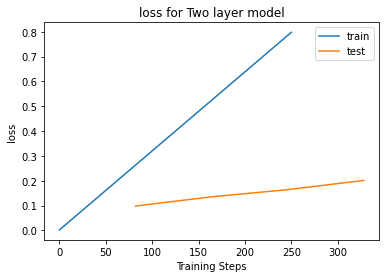

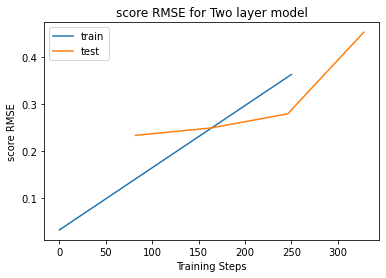

In [11]:
# Train a simple two-layer fully connected model
class TwoLayerModel(nn.Module):
  def __init__(self):
    super(TwoLayerModel, self).__init__()
    channels = 1 if DEPTH_ONLY else 4
    self.net = nn.Sequential(
      Flatten(), 
      nn.Linear(PATCH_SIZE*PATCH_SIZE*channels, 64),
      nn.ReLU(), 
      nn.Linear(64, 4))
    
  def forward(self, x):
    return self.net(x)

model_2layer = TwoLayerModel().to(device)

# Configure the training
loss = nn.MSELoss()
optimizer = optim.RMSprop(model_2layer.parameters(), lr=0.001, weight_decay=0.01)
training_epochs=4  #this is a simple model, so training will converge in only -34 epochs
metrics = train(model_2layer, train_loader, test_loader, loss, optimizer, training_epochs)
torch.save(model_2layer.state_dict(), "model_2layer.pkl")  #save to disk
plot_graphs("Two layer model",metrics)

#to load a prior model, run this code rather than optimizing
#model_2layer.load_state_dict(torch.load("model_2layer.pkl"))

Epoch 0 step 0: Train Loss: 0.000819, Score RMSE: 0.027225
Epoch 0: Test Loss: 0.079256, Score RMSE: 0.237651, time: 0.3s
Epoch 1: Test Loss: 0.076371, Score RMSE: 0.231045, time: 0.4s
Epoch 2: Test Loss: 0.077142, Score RMSE: 0.230889, time: 0.3s
Epoch 3 step 250: Train Loss: 0.088332, Score RMSE: 0.253434
Epoch 3: Test Loss: 0.077061, Score RMSE: 0.233201, time: 0.3s
Epoch 4: Test Loss: 0.084367, Score RMSE: 0.257374, time: 0.3s
Epoch 5: Test Loss: 0.075451, Score RMSE: 0.230959, time: 0.3s
Epoch 6 step 500: Train Loss: 0.076075, Score RMSE: 0.227051
Epoch 6: Test Loss: 0.075844, Score RMSE: 0.231944, time: 0.3s
Epoch 7: Test Loss: 0.081193, Score RMSE: 0.245194, time: 0.3s
Epoch 8: Test Loss: 0.079671, Score RMSE: 0.234028, time: 0.3s
Epoch 9 step 750: Train Loss: 0.075323, Score RMSE: 0.224342
Epoch 9: Test Loss: 0.077479, Score RMSE: 0.236550, time: 0.3s
Final Test Loss: 0.077479, Test RMSE: 0.236550, Total time: 3.4s


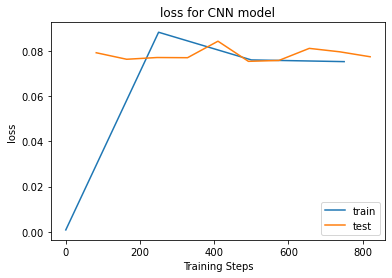

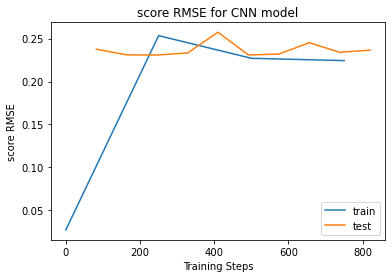

In [33]:
import torchvision as tv
    
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        channels = 1 if DEPTH_ONLY else 4
        #TODO: create your model
        self.transform = AddGaussianOffset()
        self.net = nn.Sequential(
            nn.Conv2d(channels, 16, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(channels**2, 16, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            Flatten(),
            nn.Linear(channels**2*7*7, 30),
            nn.ReLU(),
            nn.Linear(30,4)
        )
    
    def forward(self, x):
        x = x.cpu()
        x[:,3] = self.transform(x[:,3])
        x = x.to(device)
        x = self.net(x)
        return x

training_epochs = 10
loss = nn.MSELoss()
model_cnn = CNNModel().to(device)
optimizer = optim.RMSprop(model_cnn.parameters(), lr=0.001, weight_decay=0.01)
metrics = train(model_cnn, train_loader, test_loader, loss, optimizer, training_epochs)
torch.save(model_cnn.state_dict(), "model_cnn.pkl")  #save to disk
plot_graphs("CNN model",metrics)

#to load a prior model, run this code rather than optimizing
#model_cnn.load_state_dict(torch.load("model_cnn.pkl"))


### Problem 2.B

Now, go back to `make_patch_dataset` and the `ToTorchDataset` class in the cell above to improve the output.  As in MP7, the basic function has a high likelihood of oversampling low-quality regions and undersampling high quality grasps.  First, you should modify `problem2.py` to balance the patch dataset to include more pixels with higher quality grasps.

Next, implement data augmentation to ensure that the learner ignores certain characteristics of the images when making its predictions.  This is done using a Transform object from PyTorch, and is described in more detail in the [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).  You can use the torchvision [ColorJitter](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ColorJitter) function to modify color.  The absolute depth also shouldn't affect the prediction much, so you can get better generalization by adding jitter to the depth channel (such as the `AddGaussianOffset` modifier).  But don't go crazy adding huge offsets, because the depth changes the size of objects relative to the gripper width.

Report the changes that you get in the training/testing accuracy in the area for written answers below.

The code below does grasp attribute prediction for all pixels one of your test images. Let it run once, and keep the output in your submitted notebook.


In [28]:
#This creates one prediction image for your CNN model
#images = training_set.patch_dataset.dataset
images = testing_set.patch_dataset.dataset
color,depth,transform,grasp_attrs = images[0]
patch_radius = training_set.patch_dataset.patch_size//2
grasp_preds = np.zeros((480,640,4))
for y in range(color.shape[0]):
    if y%5 == 0:
        print("Working on row",y)
    all_patches = []
    for x in range(color.shape[1]):
        roi = (y-patch_radius,y+patch_radius,x-patch_radius,x+patch_radius)
        patch1 = problem2.get_region_of_interest(color,roi)
        patch2 = problem2.get_region_of_interest(depth,roi)
        if DEPTH_ONLY:
            image_packed = patch2[np.newaxis,:,:].astype(np.float32)
        else:
            image_packed = np.append(np.transpose(patch1,(2,0,1)),patch2[np.newaxis,:,:],0).astype(np.float32)
        all_patches.append(image_packed)
    model_cnn.eval()
    with torch.no_grad():
        all_predictions = model_cnn.forward(torch.from_numpy(np.array(all_patches)))
    all_predictions = all_predictions.cpu()
    grasp_preds[y] = all_predictions.numpy().reshape((640,4))


Working on row 0
Working on row 5
Working on row 10
Working on row 15
Working on row 20
Working on row 25
Working on row 30
Working on row 35
Working on row 40
Working on row 45
Working on row 50
Working on row 55
Working on row 60
Working on row 65
Working on row 70
Working on row 75
Working on row 80
Working on row 85
Working on row 90
Working on row 95
Working on row 100
Working on row 105
Working on row 110
Working on row 115
Working on row 120
Working on row 125
Working on row 130
Working on row 135
Working on row 140
Working on row 145
Working on row 150
Working on row 155
Working on row 160
Working on row 165
Working on row 170
Working on row 175
Working on row 180
Working on row 185
Working on row 190
Working on row 195
Working on row 200
Working on row 205
Working on row 210
Working on row 215
Working on row 220
Working on row 225
Working on row 230
Working on row 235
Working on row 240
Working on row 245
Working on row 250
Working on row 255
Working on row 260
Working on row 

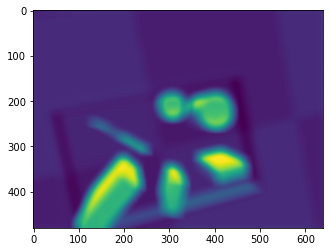

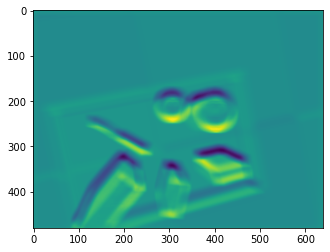

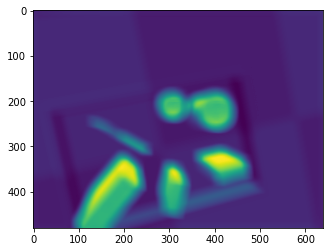

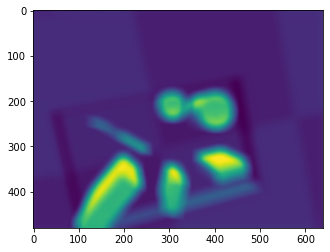

In [29]:
#Show each of your predictions
plt.imshow(grasp_preds[:,:,0])
plt.show()
plt.imshow(grasp_preds[:,:,1])
plt.show()
plt.imshow(grasp_preds[:,:,2])
plt.show()
plt.imshow(grasp_preds[:,:,3])
plt.show()

## Problem 3: Whole-image prediction (IR2 section only)

Now that you've gotten the hang of writing networks, we'll try to predict the score over a whole image.  We don't want to use the same patch extraction pipeline as before on a per-pixel basis, since it's expensive and will take minutes.  We also don't want to resort to block hacking like in MP7. Instead, we'll use a method similar to the popular U-net architecture for image segmentation.

The idea is that there will be three steps of convolution with downsampling; the resulting 8x downsampled image is assumed to have absorbed enough information from a patch of neighboring pixels to be treated like a feature.  The coarsest level of features will then be
- [upsampled](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html) by 2x
- [concatenated](https://pytorch.org/docs/stable/generated/torch.cat.html#torch.cat) with the 4x downsampled image.
- Passed through a convolutional layer
- Finally, followed by a ReLU (no max-pooling). 

The result of this level is then treated as the features at the second coarsest level; repeating this process again will give you features for the second finest level, and then repeating a final time will give you features for the output level.

The example code below does this for a single stages of paired downsampling / upsampling layers.  Repeat this to complete 3 or more stages. Note that the work needs to be done within the `forward` call, and isn't as simple as calling a Sequence.  Furthermore, for PyTorch to automatically discover the parameters of your network, each module that you use should be an attribute of `self`.

Run the subsequent cell to show your predictions.  You may try to improve your results.  If so, what did you try to improve them, and if not, what do you think you could do to improve them?  Give your answers in the spaces for written answers below.

In [ ]:
class WholeImageDataset:
    def __init__(self,folder,split_start=0,split_end=0.75):
        self.dataset = problem2.load_images_dataset(folder)
        N = len(self.dataset)
        self.dataset = self.dataset[int(N*split_start):int(N*split_end)]
        self.color_transform = None
        self.depth_transform = None
        self.color_transform = transforms.ColorJitter(0.2,0.2,0.5,0.5)
        self.depth_transform = AddGaussianOffset(0,0.2)
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,idx):
        color,depth,transform,grasp_attrs = self.dataset[idx]
        color = TF.to_tensor(color)
        depth = torch.from_numpy(depth[np.newaxis,:,:].astype(np.float32))
        if self.color_transform is not None:
            color = self.color_transform(TF.to_pil_image(color))
            color = TF.to_tensor(color)
        if self.depth_transform is not None:
            depth = self.depth_transform(depth)
        if DEPTH_ONLY:
            packed_image = depth
        else:
            packed_image = torch.cat((color,depth))
        return packed_image,np.array([grasp_attrs[v] for v in ['score','opening','axis_heading','axis_elevation']],dtype=np.float32)

whole_image_training_set = WholeImageDataset('image_dataset',0,0.75)
whole_image_testing_set = WholeImageDataset(whole_image_training_set.dataset,0.75,1)
whole_image_testing_set.color_transform = None
whole_image_testing_set.depth_transform = None
whole_image_train_loader = torch.utils.data.DataLoader(whole_image_training_set,batch_size = BATCH_SIZE,shuffle=True,**kwargs)
whole_image_test_loader = torch.utils.data.DataLoader(whole_image_testing_set,batch_size = BATCH_SIZE,shuffle=True,**kwargs)


In [ ]:

class FullImagePredictionModel(nn.Module):
    def __init__(self):
        super(FullImagePredictionModel,self).__init__()
        channels = 1 if DEPTH_ONLY else 4
        self.stage1 = nn.Sequential(
            nn.Conv2d(channels,16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.upsample_x2 = nn.Upsample(None,(2,2))
        self.relu = nn.ReLU()
        self.conv_up1 = nn.Conv2d(16+channels,16,kernel_size=3,stride=1,padding=1)
        self.conv_out = nn.Conv2d(16,4,kernel_size=3,stride=1,padding=1)

    def forward(self, x):
        #this stage reduces the dimension of the image
        downsample1 = self.stage1.forward(x)
        #this stage upsamples it back to the original resolution
        upsample1 = self.upsample_x2.forward(downsample1)
        #now concatenate...
        merged1 = torch.cat((upsample1,x),1)
        #and convolve + ReLU...
        conv1 = self.relu.forward(self.conv_up1.forward(merged1))
        #one last time!
        return self.conv_out.forward(conv1)

model_image_prediction = FullImagePredictionModel().to(device)

training_epochs=10
optimizer = optim.RMSprop(model_image_prediction.parameters(), lr=0.001, weight_decay=0.01)
metrics = train(model_image_prediction, whole_image_train_loader, whole_image_test_loader, loss, optimizer, training_epochs, calc_rmse=False)
torch.save(model_image_prediction.state_dict(), "model_image_prediction.pkl")  #save to disk

#to load a prior model, run this code rather than optimizing
#model_image_prediction.load_state_dict(torch.load("model_image_prediction.pkl"))

In [ ]:
with torch.no_grad():
    output = model_image_prediction.forward(whole_image_training_set[20][0].unsqueeze(0)).numpy()[0]
    grasp_score = output[0,:,:]
    plt.imshow(grasp_score)

## Written responses

### Written response for Problem 2.A

Compared to the simple two layer network, the CNN seemed to converge nearly instantaneously, as the training curves show a minute oscillation around 0.014 loss for the CNN while the simple network spiked to 1.0 loss before converging at roughtly 0.015 loss after 3 epochs. When analyzing the training time, the simple network understandably took less time to train than the CNN, taking about 2.2s compared to 3.6s for the CNN. The final test RMSE between the simple network and the CNN shows similar performance, with the CNN performing slightly better with an RMSE of 0.101 as compared to the simple network's 0.103.

### Written response for Problem 2.B

Filtering the data for grasps with good scores greatly improved training speed and generalization, as there were less samples to process that were more evenly distrbuted. In addition, the CNN did not instantly converge to the data, thus not overfitting to bad grasps. Adding data augmentation slightly reduced RMSE with the optimized dataset, though adding augmentation seemed to prevent quick overfitting based on the training curves.

### Written response for Problem 3

Put your answer here.